<a href="https://colab.research.google.com/github/samsung-chow/324-Project/blob/main/MLP_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

In [4]:
# Load data
use_cols_games = ['gameId', 'hometeamId', 'awayteamId', 'winner']
games_df = pd.read_csv('/content/drive/MyDrive/nba/Games.csv', usecols=use_cols_games, low_memory=False, nrows=50000)

use_cols_stats = ['teamId', 'seasonWins', 'seasonLosses']
team_stats_df = pd.read_csv('/content/drive/MyDrive/nba/TeamStatistics.csv', usecols=use_cols_stats, low_memory=False, nrows=50000)

use_cols_player_stats = ['personId', 'points', 'assists', 'reboundsTotal']
player_stats_df = pd.read_csv('/content/drive/MyDrive/nba/PlayerStatistics.csv', usecols=use_cols_player_stats, low_memory=False, nrows=50000)

# Handle missing values
games_df.fillna({'hometeamId': -1, 'awayteamId': -1, 'winner': -1}, inplace=True)
team_stats_df.fillna({'teamId': -1, 'seasonWins': 0, 'seasonLosses': 1}, inplace=True)
player_stats_df.fillna(0, inplace=True)

# Convert data types
games_df[['hometeamId', 'awayteamId', 'winner']] = games_df[['hometeamId', 'awayteamId', 'winner']].astype('int32')
team_stats_df[['teamId', 'seasonWins', 'seasonLosses']] = team_stats_df[['teamId', 'seasonWins', 'seasonLosses']].astype('int16')

# Compute Home Team Win Indicator
games_df['HomeTeamWins'] = (games_df['winner'] == games_df['hometeamId']).astype(int)

# Merge additional data
team_stats_df['WinPct'] = team_stats_df['seasonWins'] / (team_stats_df['seasonWins'] + team_stats_df['seasonLosses'])

# Aggregate player statistics per team
player_avg_stats = player_stats_df.groupby('personId')[['points', 'assists', 'reboundsTotal']].mean().reset_index()

# Merge team statistics
games_df = games_df.merge(team_stats_df[['teamId', 'WinPct', 'seasonWins', 'seasonLosses']], left_on='hometeamId', right_on='teamId', how='left')
games_df.rename(columns={'WinPct': 'WinPct_home', 'seasonWins': 'seasonWins_home', 'seasonLosses': 'seasonLosses_home'}, inplace=True)
games_df.drop(columns=['teamId'], inplace=True)

games_df = games_df.merge(team_stats_df[['teamId', 'WinPct', 'seasonWins', 'seasonLosses']], left_on='awayteamId', right_on='teamId', how='left')
games_df.rename(columns={'WinPct': 'WinPct_away', 'seasonWins': 'seasonWins_away', 'seasonLosses': 'seasonLosses_away'}, inplace=True)
games_df.drop(columns=['teamId'], inplace=True)

# Selecting features
games_df.fillna(0, inplace=True)
games_df['WinPct_Diff'] = games_df['WinPct_home'] - games_df['WinPct_away']
games_df['RecentPerformance'] = games_df['WinPct_home'] * 0.6 + games_df['WinPct_away'] * 0.4
games_df['seasonWinRate_home'] = games_df['seasonWins_home'] / (games_df['seasonWins_home'] + games_df['seasonLosses_home'] + 1)
games_df['seasonWinRate_away'] = games_df['seasonWins_away'] / (games_df['seasonWins_away'] + games_df['seasonLosses_away'] + 1)

games_df['AvgPlayerPoints'] = player_avg_stats['points'].mean()
games_df['AvgPlayerAssists'] = player_avg_stats['assists'].mean()
games_df['AvgPlayerRebounds'] = player_avg_stats['reboundsTotal'].mean()

X = games_df[['WinPct_Diff', 'RecentPerformance', 'seasonWinRate_home', 'seasonWinRate_away', 'AvgPlayerPoints', 'AvgPlayerAssists', 'AvgPlayerRebounds']]
y = games_df['HomeTeamWins']

# Convert DataFrame to numpy arrays
X_numpy = X.to_numpy()
y_numpy = y.to_numpy()

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_numpy), y=y_numpy)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_numpy, y_numpy, test_size=0.2, random_state=42, stratify=y_numpy)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


Class Distribution:
Class 0: 19929 samples (39.86%)
Class 1: 30071 samples (60.14%)


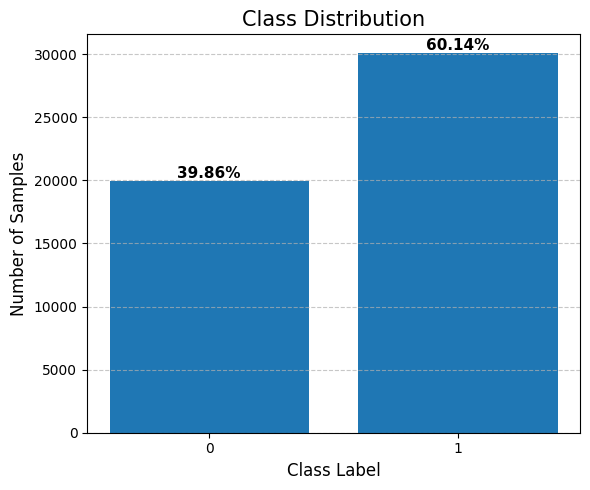

In [11]:
# Compute class distribution
unique, counts = np.unique(y_numpy, return_counts=True)

# Print class distribution
print("Class Distribution:")
percentages = []
for label, count in zip(unique, counts):
    percentage = count / len(y_numpy) * 100
    percentages.append(percentage)
    print(f"Class {label}: {count} samples ({percentage:.2f}%)")

# Plot bar graph
plt.figure(figsize=(6, 5))
bars = plt.bar(unique.astype(str), counts)

# Add percentage labels on top of bars
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{pct:.2f}%",
        ha='center',
        va='bottom',
        fontsize=11,  # Increased font size
        fontweight='bold'
    )

plt.title("Class Distribution", fontsize=15)
plt.xlabel("Class Label", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [12]:
# Define feature names and sample values
feature_names = [
    "WinPct_Diff", "RecentPerformance", "seasonWinRate_home",
    "seasonWinRate_away", "AvgPlayerPoints", "AvgPlayerAssists", "AvgPlayerRebounds"
]

sample_input = X_numpy[0]
sample_output = y_numpy[0]

# Create a DataFrame for better formatting
sample_df = pd.DataFrame([sample_input], columns=feature_names)
sample_df.index = ["Sample Input"]

# Display input information
print(f"\nNumber of Input Features: {X.shape[1]}")
print("\nInput Features and Values:\n")
print(sample_df.to_string())

# Display output label meaning
print(f"\nSample Output Label: {sample_output}  -->  {'Home team won' if sample_output == 1 else 'Away team won'}")



Number of Input Features: 7

Input Features and Values:

              WinPct_Diff  RecentPerformance  seasonWinRate_home  seasonWinRate_away  AvgPlayerPoints  AvgPlayerAssists  AvgPlayerRebounds
Sample Input          0.0                0.0                 0.0                 0.0         6.318761           1.50432           2.555908

Sample Output Label: 0  -->  Away team won


In [17]:
class MLPModel(nn.Module):
    def __init__(self, input_size):
        super(MLPModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize Model
num_input_features = X_train_tensor.shape[1]
device = "cuda" if torch.cuda.is_available() else "cpu"

model = MLPModel(num_input_features).to(device)
# Model summary
summary(model, input_size=(num_input_features,))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]           4,096
       BatchNorm1d-2                  [-1, 512]           1,024
              GELU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
       BatchNorm1d-6                  [-1, 256]             512
              GELU-7                  [-1, 256]               0
           Dropout-8                  [-1, 256]               0
            Linear-9                  [-1, 128]          32,896
      BatchNorm1d-10                  [-1, 128]             256
             GELU-11                  [-1, 128]               0
          Dropout-12                  [-1, 128]               0
           Linear-13                   [-1, 64]           8,256
             GELU-14                   

Epoch 1/20 | Train Loss: 0.1277 | Train Acc: 60.14% | Test Loss: 0.1300 | Test Acc: 39.86%
Epoch 2/20 | Train Loss: 0.1267 | Train Acc: 60.14% | Test Loss: 0.1299 | Test Acc: 60.14%
Epoch 3/20 | Train Loss: 0.1266 | Train Acc: 60.14% | Test Loss: 0.1300 | Test Acc: 60.14%
Epoch 4/20 | Train Loss: 0.1267 | Train Acc: 60.14% | Test Loss: 0.1299 | Test Acc: 60.14%
Epoch 5/20 | Train Loss: 0.1266 | Train Acc: 60.14% | Test Loss: 0.1299 | Test Acc: 60.14%
Epoch 6/20 | Train Loss: 0.1266 | Train Acc: 60.14% | Test Loss: 0.1279 | Test Acc: 60.14%
Epoch 7/20 | Train Loss: 0.1266 | Train Acc: 60.14% | Test Loss: 0.1299 | Test Acc: 60.14%
Epoch 8/20 | Train Loss: 0.1266 | Train Acc: 60.14% | Test Loss: 0.1282 | Test Acc: 60.14%
Epoch 9/20 | Train Loss: 0.1266 | Train Acc: 60.14% | Test Loss: 0.1290 | Test Acc: 60.14%
Epoch 10/20 | Train Loss: 0.1265 | Train Acc: 60.14% | Test Loss: 0.1290 | Test Acc: 60.14%
Epoch 11/20 | Train Loss: 0.1266 | Train Acc: 60.14% | Test Loss: 0.1276 | Test Acc: 60.1

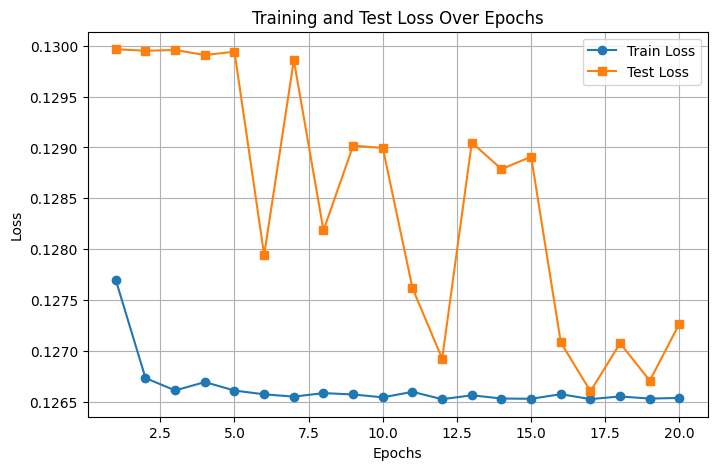

In [20]:
batch_size = 32

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Focal Loss to handle class imbalance
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.75):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return loss.mean()

# Initialize model, optimizer, and scheduler
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MLPModel(X_train_tensor.shape[1]).to(device)  # Ensure model is defined

criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

# Training loop
epochs = 20
train_losses = []
test_losses = []
epochs_list = []

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).view(-1, 1)
        optimizer.zero_grad()
        y_pred = model(X_batch)

        # Compute loss
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Compute training accuracy
        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        correct += (y_pred_class == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total * 100
    scheduler.step()
    train_losses.append(train_loss)  # Store train loss
    epochs_list.append(epoch + 1)

    # Evaluation loop
    model.eval()
    test_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).view(-1, 1)
            y_pred = model(X_batch)

            # Compute test loss
            loss = criterion(y_pred, y_batch)
            test_loss += loss.item()

            # Compute test accuracy
            y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
            correct += (y_pred_class == y_batch).sum().item()
            total += y_batch.size(0)

    test_loss /= len(test_loader)
    test_accuracy = correct / total * 100
    test_losses.append(test_loss)  # Store test loss

    # Print training stats
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_accuracy:.2f}%")

# Plot training and test loss
plt.figure(figsize=(8, 5))
plt.plot(epochs_list, train_losses, label="Train Loss", marker="o")
plt.plot(epochs_list, test_losses, label="Test Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Check Prediction Distribution
y_pred = (torch.sigmoid(model(X_test_tensor.to(device))) > 0.5).cpu().numpy()
unique, counts = np.unique(y_pred, return_counts=True)


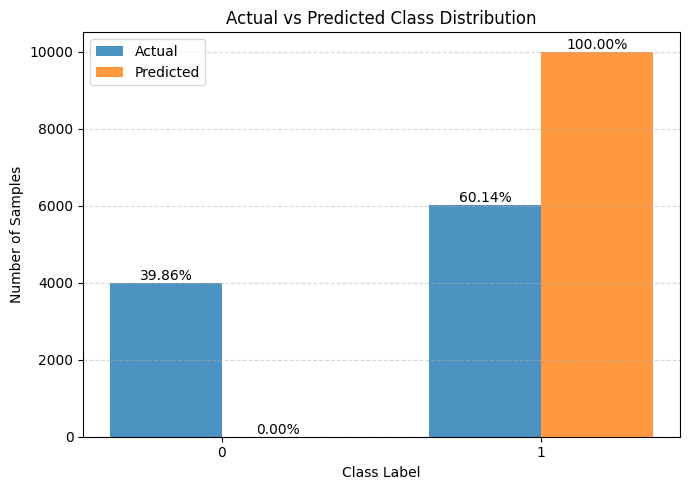

Final Test Accuracy: 60.14%


In [21]:
# Compute actual and predicted distributions
actual_labels = y_test_tensor.cpu().numpy().flatten()
predicted_labels = y_pred.flatten()

actual_unique, actual_counts = np.unique(actual_labels, return_counts=True)
pred_unique, pred_counts = np.unique(predicted_labels, return_counts=True)
classes = sorted(set(np.unique(actual_labels)).union(np.unique(predicted_labels)))
actual_dist = [actual_counts[np.where(actual_unique == cls)[0][0]] if cls in actual_unique else 0 for cls in classes]
pred_dist = [pred_counts[np.where(pred_unique == cls)[0][0]] if cls in pred_unique else 0 for cls in classes]

# Plot bar graph
x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(7, 5))
bars1 = plt.bar(x - width/2, actual_dist, width, label='Actual', alpha=0.8)
bars2 = plt.bar(x + width/2, pred_dist, width, label='Predicted', alpha=0.8)

# Add percentage annotations
for bar, total in zip(bars1, [sum(actual_dist)] * len(bars1)):
    height = bar.get_height()
    pct = height / total * 100
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{pct:.2f}%", ha='center', va='bottom', fontsize=10)

for bar, total in zip(bars2, [sum(pred_dist)] * len(bars2)):
    height = bar.get_height()
    pct = height / total * 100
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{pct:.2f}%", ha='center', va='bottom', fontsize=10)

# Final plot adjustments
plt.xticks(x, [str(int(c)) for c in classes])
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Actual vs Predicted Class Distribution")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Print final test accuracy
final_accuracy = (predicted_labels == actual_labels).sum() / len(actual_labels) * 100
print(f"Final Test Accuracy: {final_accuracy:.2f}%")
